In [1]:
from keypress_recognition.models import black_key_model as bmodel
from keypress_recognition import dataset_p as dataset
import numpy as np
import matplotlib.pyplot as plt
import cv2
%load_ext autoreload
%autoreload 2

In [2]:
dataset.load_all_data(color=['black'], size=['single'], keypress=True, concatenate=True, delta=3)

Start seperating keyboard ...
  White single width: 21px
  Black single width: 20px
  White bundle width: 37px
  Black bundle width: 36px


IntProgress(value=0, max=14273)

In trainset: 
  # of pressed black key: 8755
  # of unpressed black key: 43674


IntProgress(value=0, max=5000)

In testset: 
  # of pressed black key: 761
  # of unpressed black key: 22534


IntProgress(value=0, max=2993)

In valset: 
  # of pressed black key: 817
  # of unpressed black key: 10789


In [3]:
import keypress_recognition.models as models

In [4]:
def visualize_keys(note):
    """
    note: bool
    return: str
    """
    return ("Y" if note else "N")
visualize_keys(True)

'Y'

Samples from X_train: 


IntProgress(value=0, max=87348)

(2, 106, 20, 9)
1 0
Samples from X_test: 


IntProgress(value=0, max=45068)

(2, 106, 20, 9)
1 0
Samples from X_val: 


IntProgress(value=0, max=21578)

(2, 106, 20, 9)
1 0


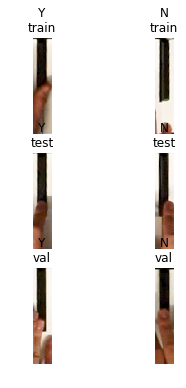

In [7]:
# print several images with labels
fig, axarr = plt.subplots(3, 2, figsize=[4, 6])
for ii, _type in enumerate(['train', 'test', 'val']):

    print(f'Samples from X_{_type}: ')

    for imgb, noteb in dataset.data_batch(type=_type, size='single', color='black', batch_size=2, NCHW=False, need_velocity=False, concatenate=True):
        print(imgb.shape)
        print(noteb[0], noteb[1])
        axarr[ii,0].imshow(cv2.cvtColor(imgb[0, :, :, 3:6], cv2.COLOR_BGR2RGB))
        axarr[ii,0].set_title(visualize_keys(noteb[0]) + '\n' + _type)
        axarr[ii,0].axis('off')
        axarr[ii,1].imshow(cv2.cvtColor(imgb[1, :, :, 3:6], cv2.COLOR_BGR2RGB))
        axarr[ii,1].set_title(visualize_keys(noteb[1]) + '\n' + _type)
        axarr[ii,1].axis('off')
        break

plt.show()

In [19]:
bmodel = models.get_black_key_model(9)

In [21]:
bmodel.train(dataset, batch_size=32, size='single', color='black',
             concatenate=True,
             num_epochs=20,
             max_num=-1,
             learning_rate=1e-4,
             best_path='keypress_recognition/best_black_model.tar',
             current_path='keypress_recognition/current_black.tar',
             method=0)

Epoch 1/20


IntProgress(value=0, max=87348)

train Loss: 0.2254
[[41531  1233]
 [ 2149 42447]]
Precision: 0.95
Recall   : 0.97
Accuracy : 0.96


IntProgress(value=0, max=21578)

val Loss: 0.4583
[[10592  1574]
 [  208  9226]]
Precision: 0.98
Recall   : 0.85
Accuracy : 0.92
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 2/20


IntProgress(value=0, max=87348)

train Loss: 0.1276
[[42554   571]
 [ 1126 43109]]
Precision: 0.97
Recall   : 0.99
Accuracy : 0.98


IntProgress(value=0, max=21578)

val Loss: 0.2782
[[10459   731]
 [  341 10069]]
Precision: 0.97
Recall   : 0.93
Accuracy : 0.95
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 3/20


IntProgress(value=0, max=87348)

train Loss: 0.0915
[[42941   325]
 [  739 43355]]
Precision: 0.98
Recall   : 0.99
Accuracy : 0.99


IntProgress(value=0, max=21578)

val Loss: 0.3389
[[10575   755]
 [  225 10045]]
Precision: 0.98
Recall   : 0.93
Accuracy : 0.95
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 4/20


IntProgress(value=0, max=87348)

train Loss: 0.0686
[[43129   213]
 [  551 43467]]
Precision: 0.99
Recall   : 1.00
Accuracy : 0.99


IntProgress(value=0, max=21578)

val Loss: 0.2469
[[10346   290]
 [  454 10510]]
Precision: 0.96
Recall   : 0.97
Accuracy : 0.97
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 5/20


IntProgress(value=0, max=87348)

train Loss: 0.0548
[[43258   135]
 [  422 43545]]
Precision: 0.99
Recall   : 1.00
Accuracy : 0.99


IntProgress(value=0, max=21578)

val Loss: 0.3697
[[10574   773]
 [  226 10027]]
Precision: 0.98
Recall   : 0.93
Accuracy : 0.95
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 6/20


IntProgress(value=0, max=87348)

train Loss: 0.0443
[[43367   108]
 [  313 43572]]
Precision: 0.99
Recall   : 1.00
Accuracy : 1.00


IntProgress(value=0, max=21578)

val Loss: 0.8129
[[10685  2119]
 [  115  8681]]
Precision: 0.99
Recall   : 0.80
Accuracy : 0.90
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 7/20


IntProgress(value=0, max=87348)

train Loss: 0.0378
[[43443    85]
 [  237 43595]]
Precision: 0.99
Recall   : 1.00
Accuracy : 1.00


IntProgress(value=0, max=21578)

val Loss: 0.6903
[[10678  1429]
 [  122  9371]]
Precision: 0.99
Recall   : 0.87
Accuracy : 0.93
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 8/20


IntProgress(value=0, max=87348)

train Loss: 0.0316
[[43501    66]
 [  179 43614]]
Precision: 1.00
Recall   : 1.00
Accuracy : 1.00


IntProgress(value=0, max=21578)

val Loss: 0.6466
[[10681  1689]
 [  119  9111]]
Precision: 0.99
Recall   : 0.84
Accuracy : 0.92
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 9/20


IntProgress(value=0, max=87348)

train Loss: 0.0273
[[43543    63]
 [  137 43617]]
Precision: 1.00
Recall   : 1.00
Accuracy : 1.00


IntProgress(value=0, max=21578)

val Loss: 0.5732
[[10677  1097]
 [  123  9703]]
Precision: 0.99
Recall   : 0.90
Accuracy : 0.94
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 10/20


IntProgress(value=0, max=87348)

train Loss: 0.0099
[[43591    14]
 [   89 43666]]
Precision: 1.00
Recall   : 1.00
Accuracy : 1.00


IntProgress(value=0, max=21578)

val Loss: 0.7058
[[10703  1355]
 [   97  9445]]
Precision: 0.99
Recall   : 0.87
Accuracy : 0.93
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 11/20


IntProgress(value=0, max=87348)

train Loss: 0.0052
[[43640     0]
 [   40 43680]]
Precision: 1.00
Recall   : 1.00
Accuracy : 1.00


IntProgress(value=0, max=21578)

val Loss: 0.7222
[[10695  1254]
 [  105  9546]]
Precision: 0.99
Recall   : 0.88
Accuracy : 0.94
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 12/20


IntProgress(value=0, max=87348)

train Loss: 0.0030
[[43660     0]
 [   20 43680]]
Precision: 1.00
Recall   : 1.00
Accuracy : 1.00


IntProgress(value=0, max=21578)

val Loss: 0.8526
[[10700  1479]
 [  100  9321]]
Precision: 0.99
Recall   : 0.86
Accuracy : 0.93
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 13/20


IntProgress(value=0, max=87348)

train Loss: 0.0019
[[43672     0]
 [    8 43680]]
Precision: 1.00
Recall   : 1.00
Accuracy : 1.00


IntProgress(value=0, max=21578)

val Loss: 0.8307
[[10692  1274]
 [  108  9526]]
Precision: 0.99
Recall   : 0.88
Accuracy : 0.94
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 14/20


IntProgress(value=0, max=87348)

train Loss: 0.0014
[[43676     0]
 [    4 43680]]
Precision: 1.00
Recall   : 1.00
Accuracy : 1.00


IntProgress(value=0, max=21578)

val Loss: 0.9181
[[10695  1350]
 [  105  9450]]
Precision: 0.99
Recall   : 0.88
Accuracy : 0.93
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 15/20


IntProgress(value=0, max=87348)

train Loss: 0.0010
[[43679     0]
 [    1 43680]]
Precision: 1.00
Recall   : 1.00
Accuracy : 1.00


IntProgress(value=0, max=21578)

val Loss: 1.0033
[[10694  1405]
 [  106  9395]]
Precision: 0.99
Recall   : 0.87
Accuracy : 0.93
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 16/20


IntProgress(value=0, max=87348)

train Loss: 0.0008
[[43680     0]
 [    0 43680]]
Precision: 1.00
Recall   : 1.00
Accuracy : 1.00


IntProgress(value=0, max=21578)

val Loss: 1.1172
[[10701  1499]
 [   99  9301]]
Precision: 0.99
Recall   : 0.86
Accuracy : 0.93
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 17/20


IntProgress(value=0, max=87348)

train Loss: 0.0007
[[43680     0]
 [    0 43680]]
Precision: 1.00
Recall   : 1.00
Accuracy : 1.00


IntProgress(value=0, max=21578)

val Loss: 1.0903
[[10697  1400]
 [  103  9400]]
Precision: 0.99
Recall   : 0.87
Accuracy : 0.93
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 18/20


IntProgress(value=0, max=87348)

train Loss: 0.0006
[[43680     0]
 [    0 43680]]
Precision: 1.00
Recall   : 1.00
Accuracy : 1.00


IntProgress(value=0, max=21578)

val Loss: 1.0238
[[10679  1295]
 [  121  9505]]
Precision: 0.99
Recall   : 0.88
Accuracy : 0.93
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 19/20


IntProgress(value=0, max=87348)

train Loss: 0.0005
[[43680     0]
 [    0 43680]]
Precision: 1.00
Recall   : 1.00
Accuracy : 1.00


IntProgress(value=0, max=21578)

val Loss: 1.1910
[[10690  1453]
 [  110  9347]]
Precision: 0.99
Recall   : 0.87
Accuracy : 0.93
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 20/20


IntProgress(value=0, max=87348)

train Loss: 0.0004
[[43680     0]
 [    0 43680]]
Precision: 1.00
Recall   : 1.00
Accuracy : 1.00


IntProgress(value=0, max=21578)

val Loss: 1.1427
[[10677  1274]
 [  123  9526]]
Precision: 0.99
Recall   : 0.88
Accuracy : 0.94
Current mode has been saved to keypress_recognition/current_black.tar ...

Training complete in 32m 42s
Best val loss: 0.246906


IntProgress(value=0, max=45068)

(12, 106, 20, 9)
tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)


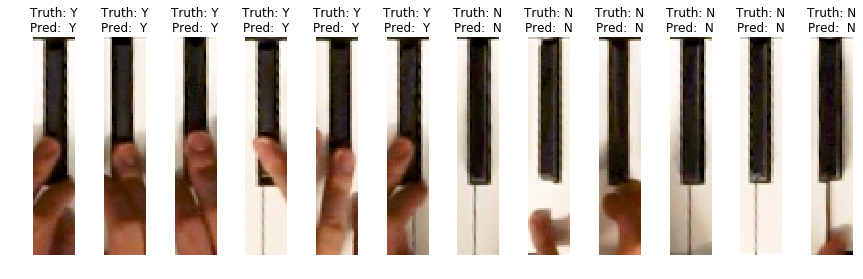

In [23]:
example_batch = 12
fig, axarr = plt.subplots(1, example_batch, figsize=(15,4))
for imgb, noteb in dataset.data_batch(type='test', size='single', color='black', batch_size=example_batch, NCHW=True, need_velocity=False, concatenate=True):
    yb = bmodel.evaluate(imgb, threshold=0.5)
    imgb = np.transpose(imgb, (0, 2, 3, 1))
    print(imgb.shape)
    print(yb)
    for i in range(example_batch):
        axarr[i].imshow(cv2.cvtColor(imgb[i, :, :, 3:6], cv2.COLOR_BGR2RGB))
        axarr[i].set_title('Truth: ' + visualize_keys(noteb[i]) + '\nPred:  ' + visualize_keys(yb[i]))
        axarr[i].axis('off')
    break
plt.show()